Обучить модель классификации изображение на 2 класса. Исходные данные и валидация решения на kaggle в рамках контеста Cats vs Dogs. Шаблон ipython-ноутбука вы найдете по ссылке в материалах к занятию. Решения необходимо прислать в виде ipython-ноутбука с указанием значения метрики на Leaderboard.

Задание засчитывается при значениях метрики Log Loss меньше 0.3.

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [2]:
import os, shutil
import numpy as np
import re
from random import shuffle
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline

from keras import layers, models, optimizers
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from IPython.display import Image


/Users/lera/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_files = glob('../input/train/*.jpg')
test_files = glob('../input/test/*.jpg')

# Функции для загрузки данных

### Загрузка входных изображений и предобработка

In [3]:
IMG_SIZE_VGG = (224, 224) 

In [4]:
def load_image(path, target_size = IMG_SIZE_VGG):
    img = load_img(path, target_size=target_size)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return preprocess_input(array)  # предобработка для VGG16

### Генератор для последовательного чтения обучающих данных с диска

In [5]:
def fit_generator(files, batch_size=32):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if re.match('.*/dog\.\d', path) else 0. for path in files[i:j]])
            yield (x, y)

### Генератор последовательного чтения тестовых данных с диска

In [6]:
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

# Визуализация примеров для обучения

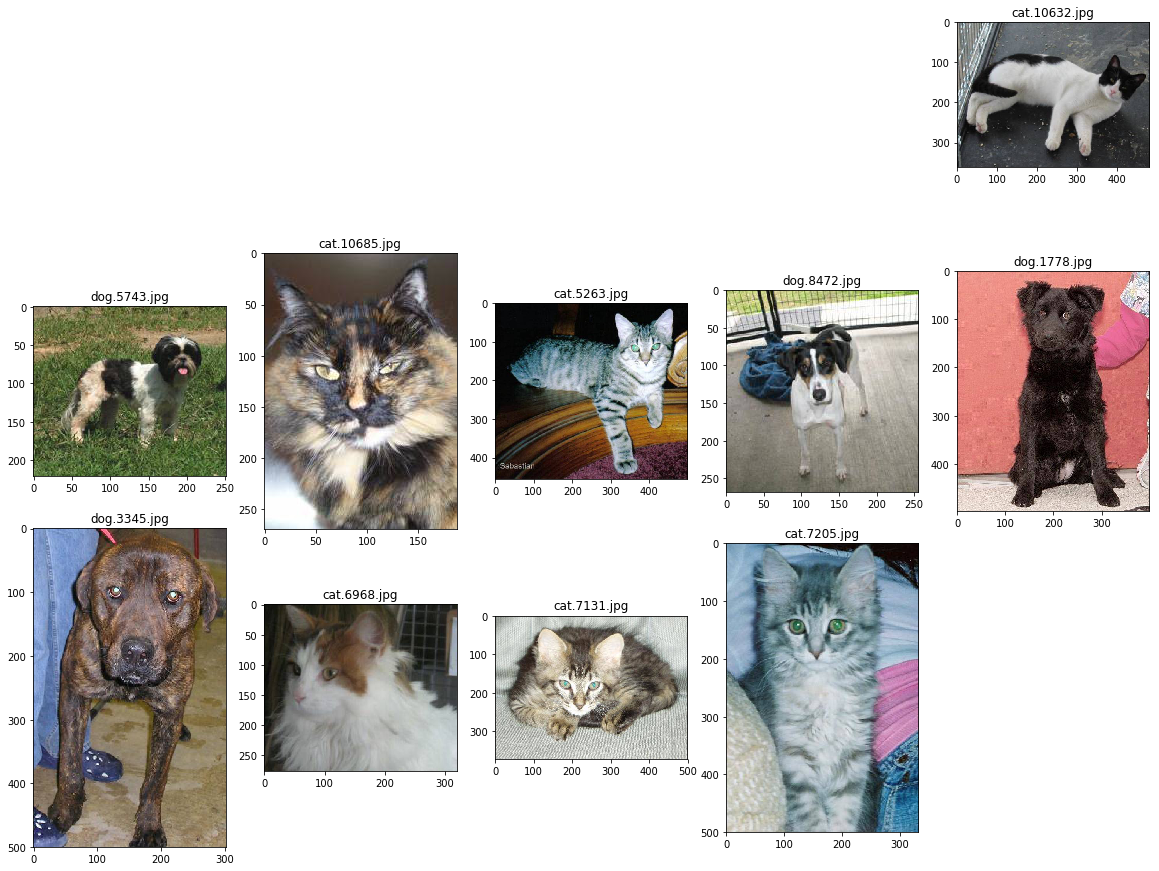

In [7]:
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%s' % path.split('/')[-1])

# Загружаю предварительно обученную нейронную сеть VGG16

## Архитектура VGG16

VGG16 - это сверточная нейронная сеть, которая содержит 16 слоев. Сеть состоит из двух частей:

Первая часть сети выделяет характерные признаки в изображении. Состоит из чередующихся каскадов свертки и подвыборки. Сначала идут два каскада свертка-свертка-подвыборка, а затем три каскада свертка-свертка-свертка-подвыборка. Размер узла свертки во всех слоях 3х3. При подвыборке производится выбор максимального значения (Max Pooling) из квадрата размером 2х2.


Вторая часть отвечает за классификацию объекта на изображении по выделенным на предыдущем этапе признакам. Эта часть содержит 3 полносвязных слоя. В первых двух слоях 4096 нейронов, а в последнем - 1000 нейронов (по количеству классов объектов).
На вход сеть VGG16, получает изображение размером 224х224 пиксела, 3 канала цвета (красный, зеленый и синий). На выходе сеть выдает вероятности (в формате one hot encoding), что на изображении тот или иной класс объекта.

https://keras.io/applications/#vgg16

https://arxiv.org/abs/1409.1556

In [8]:
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58892288/58889256 [==============================] - 5s 0us/step


"Замораживаю" веса предварительно обученной сети

In [9]:
vgg16.trainable = False

In [10]:
vgg16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### Добавляю полносвязный классификатор поверх серточной основы

In [11]:
model = models.Sequential()
model.add(vgg16)
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 512)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               6422784   
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total para

Компилирую полученную сеть

In [13]:
model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.Adam(lr=1e-5), 
              metrics=['acc'])

In [14]:
shuffle(train_files)  # перемешиваем обучающую выборку

train_val_split = 100  # число изображений в валидационной выборке

validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))

# запускаем процесс обучения
history = model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=10,  # число вызовов генератора за эпоху
        epochs=100,  # число эпох обучения
        validation_data=validation_data)

Epoch 1/100
10/10 [==============================] - 11s 1s/step - loss: 0.9203 - acc: 0.5687 - val_loss: 0.5638 - val_acc: 0.7200
Epoch 2/100
10/10 [==============================] - 4s 376ms/step - loss: 0.7538 - acc: 0.6406 - val_loss: 0.4468 - val_acc: 0.7900
Epoch 3/100
10/10 [==============================] - 4s 372ms/step - loss: 0.6779 - acc: 0.6781 - val_loss: 0.3710 - val_acc: 0.8800
Epoch 4/100
10/10 [==============================] - 4s 373ms/step - loss: 0.5339 - acc: 0.7438 - val_loss: 0.3087 - val_acc: 0.8900
Epoch 5/100
10/10 [==============================] - 4s 375ms/step - loss: 0.5540 - acc: 0.7438 - val_loss: 0.2664 - val_acc: 0.9000
Epoch 6/100
10/10 [==============================] - 4s 374ms/step - loss: 0.5315 - acc: 0.7219 - val_loss: 0.2353 - val_acc: 0.9100
Epoch 7/100
10/10 [==============================] - 4s 376ms/step - loss: 0.4483 - acc: 0.7844 - val_loss: 0.2121 - val_acc: 0.9100
Epoch 8/100
10/10 [==============================] - 4s 377ms/step - lo

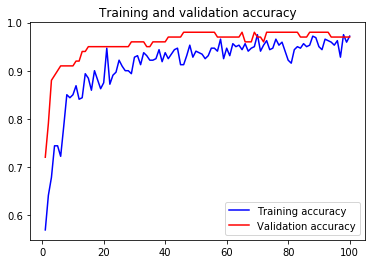

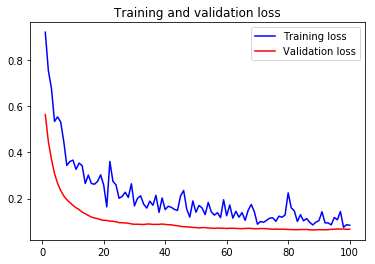

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [16]:
pred = model.predict_generator(predict_generator(test_files), len(test_files), max_queue_size=500)

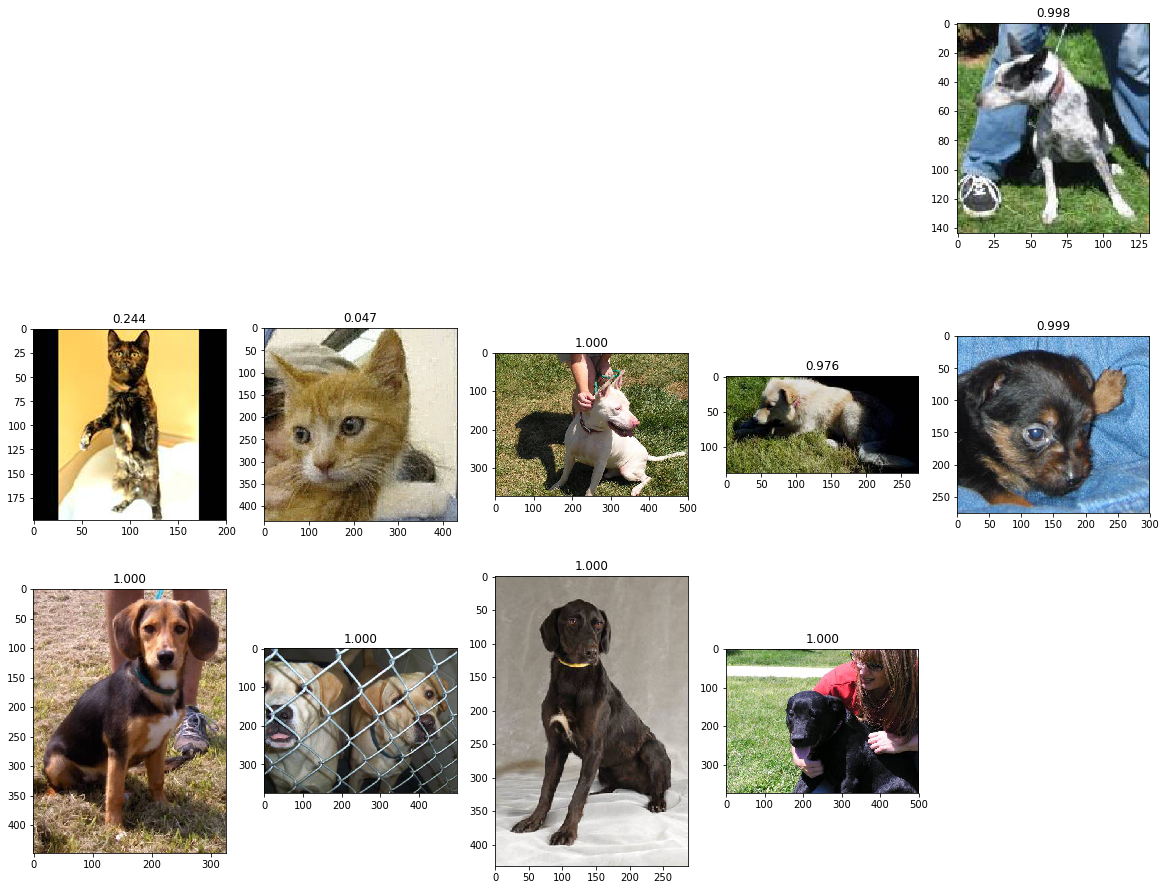

In [17]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, (path, score) in enumerate(zip(test_files[80:][:10], pred[80:][:10]), 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%.3f' % score);

In [18]:
with open('submit_vgg16_drop_norm.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, pred):
        dst.write('%s,%f\n' % (re.search('(\d+)', path).group(0), score))

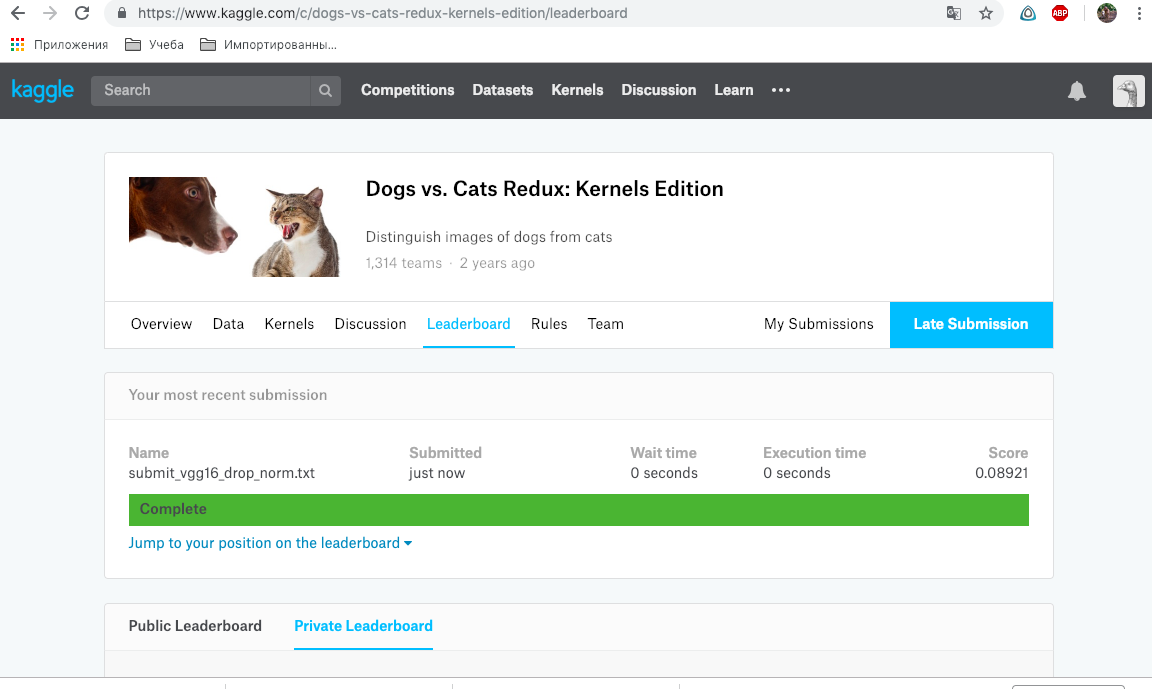

In [4]:
Image('submit_vgg16_drop_norm.png')

### Дообучу модель, "разморозив" последний сверточный блок сети VGG16¶


In [19]:
vgg16.trainable = True
set_trainable = False
for layer in vgg16.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else: 
        layer.trainable = False

In [20]:
len(model.trainable_weights)

12

In [21]:
model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.Adam(lr=1e-5), 
              metrics=['acc'])

In [22]:
shuffle(train_files)  # перемешиваем обучающую выборку

train_val_split = 100  # число изображений в валидационной выборке

validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))

# запускаем процесс обучения
history = model.fit_generator(fit_generator(train_files[train_val_split:]),  # данные читаем функцией-генератором
        steps_per_epoch=10,  # число вызовов генератора за эпоху
        epochs=100,  # число эпох обучения
        validation_data=validation_data)

Epoch 1/100
10/10 [==============================] - 7s 693ms/step - loss: 0.0809 - acc: 0.9656 - val_loss: 0.0211 - val_acc: 1.0000
Epoch 2/100
10/10 [==============================] - 4s 416ms/step - loss: 0.0923 - acc: 0.9594 - val_loss: 0.0281 - val_acc: 0.9900
Epoch 3/100
10/10 [==============================] - 4s 417ms/step - loss: 0.0928 - acc: 0.9437 - val_loss: 0.0295 - val_acc: 0.9900
Epoch 4/100
10/10 [==============================] - 4s 417ms/step - loss: 0.0972 - acc: 0.9563 - val_loss: 0.0248 - val_acc: 0.9900
Epoch 5/100
10/10 [==============================] - 4s 416ms/step - loss: 0.0886 - acc: 0.9656 - val_loss: 0.0156 - val_acc: 1.0000
Epoch 6/100
10/10 [==============================] - 4s 417ms/step - loss: 0.1040 - acc: 0.9563 - val_loss: 0.0119 - val_acc: 1.0000
Epoch 7/100
10/10 [==============================] - 4s 415ms/step - loss: 0.1352 - acc: 0.9500 - val_loss: 0.0105 - val_acc: 1.0000
Epoch 8/100
10/10 [==============================] - 4s 415ms/step - 

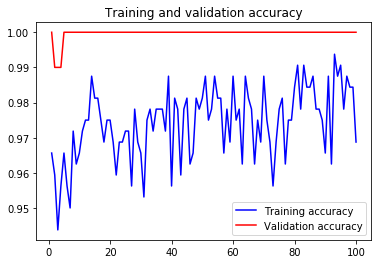

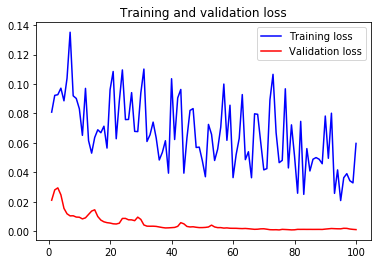

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'b', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.plot(epochs, loss, 'b', label = 'Training loss')
plt.plot(epochs, val_loss, 'r', label = 'Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [24]:
pred = model.predict_generator(predict_generator(test_files), len(test_files), max_queue_size=500)

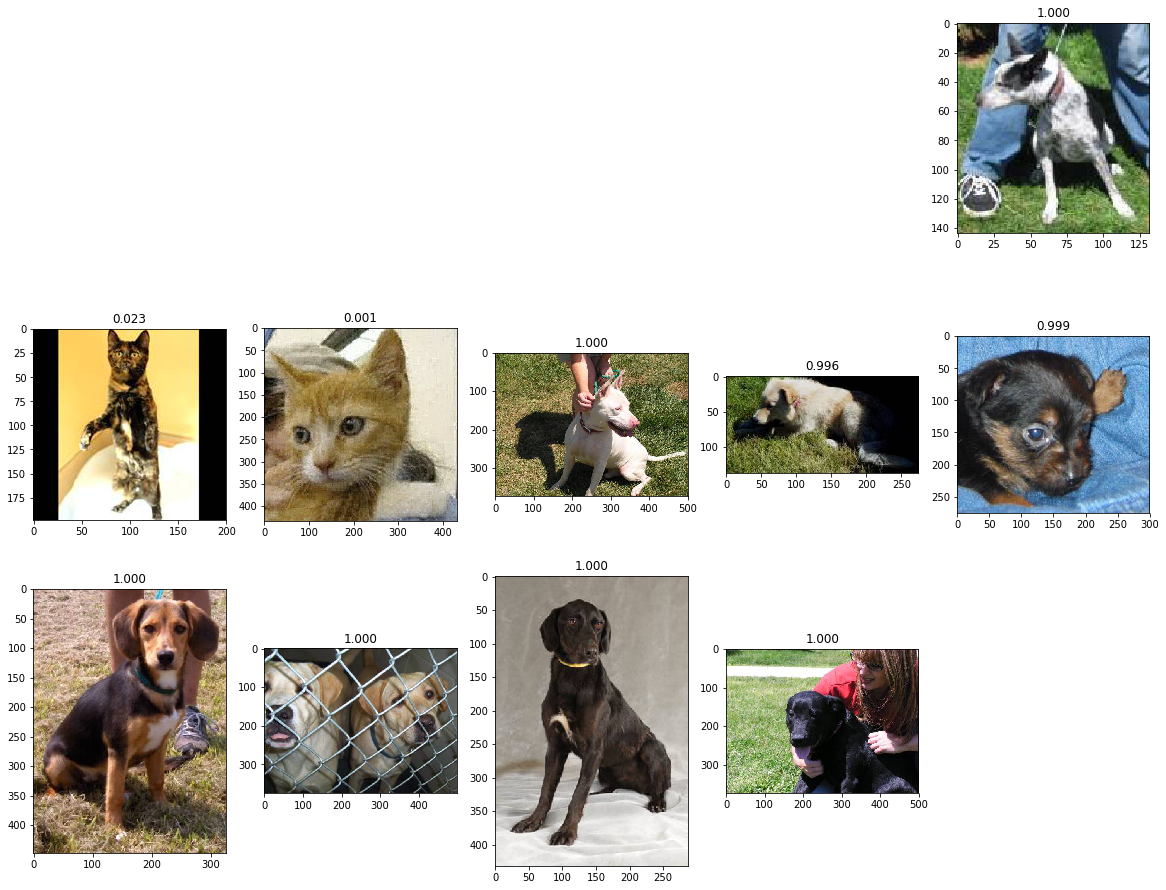

In [25]:
fig = plt.figure(figsize=(20, 20))
for i, (path, score) in enumerate(zip(test_files[80:][:10], pred[80:][:10]), 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%.3f' % score);

In [26]:
with open('submit_vgg16_drop_norm_2.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, pred):
        dst.write('%s,%f\n' % (re.search('(\d+)', path).group(0), score))

In [27]:
model.save('cats_and_dogs_vgg16_2.hdf5')

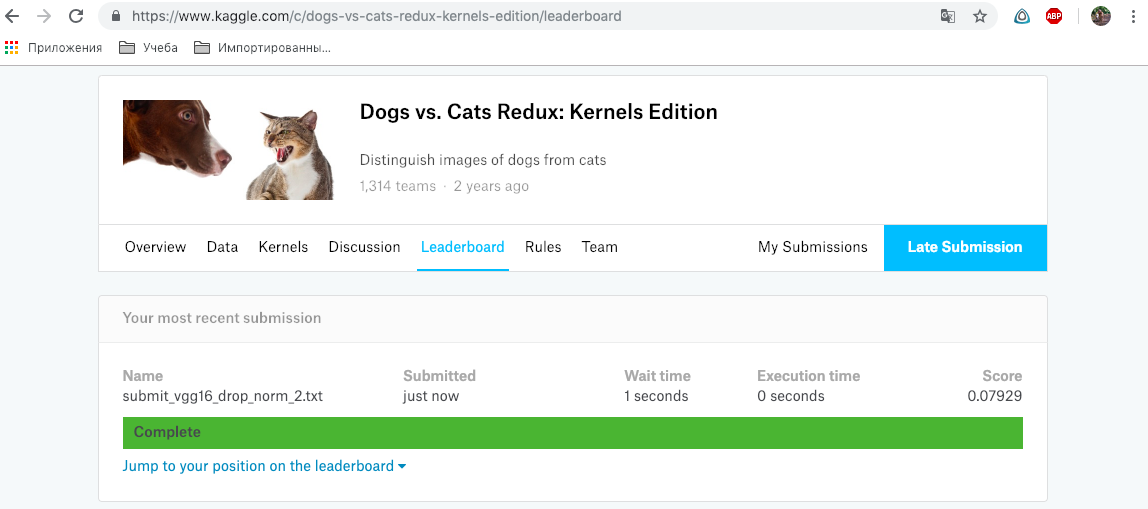

In [5]:
Image('submit_vgg16_drop_norm_2.png')

Результат получился на 0.01 лучше